# Retreiving data from mongodb

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import pymongo
from pymongo import MongoClient
client = MongoClient()
db = client.starbucks

collection1 = db.data1
allOffers= pd.DataFrame(list(collection1.find()))

collection2 = db.data2
allTransactions= pd.DataFrame(list(collection2.find()))



## Droping Unwanted Columns

In [ ]:
allOffers.head(2)
allOffers = allOffers.drop(["_id"],axis=1)
allOffers.head(2)

,age,became_member_on,channels,difficulty,duration,event,gender,income,offer_id,offer_type,person,reward,time
0,32,2015-10-07 18:30:00,"[email, mobile, social]",0,3.0,offer received,M,38000,5a8bc65990b245e5a138643cd4eb9837,informational,27aa749a6f5f448e91327028a2ac7fb5,0,0
1,62,2016-05-01 18:30:00,"[email, mobile, social]",0,3.0,offer received,F,98000,5a8bc65990b245e5a138643cd4eb9837,informational,abf29a94ba3d4648869ad7505d863e22,0,0


In [ ]:
allTransactions.head(2)
allTransactions = allTransactions.drop(["_id"],axis=1)
allTransactions.head(2)

,age,became_member_on,event,gender,income,person,time,trans_amount
0,51,2015-12-15 18:30:00,transaction,M,81000,2fb4578848f34ce4b779cdf4e7baa732,0,21.4
1,40,2017-11-13 18:30:00,transaction,M,39000,6851449a9192478d86ae6c22e8b93200,0,2.3


# One hot encoding

In [ ]:
#allOffers.to_csv(r"C:\Users\Rahul\Desktop\DBDA Project\project\allOffers.csv", index=False)

In [ ]:
#allTransactions.to_csv(r"C:\Users\Rahul\Desktop\DBDA Project\project\allTransactions.csv", index=False)

In [ ]:
# channel dummies

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
channel_dummies = pd.DataFrame(mlb.fit_transform(allOffers['channels']), columns=mlb.classes_, index=allOffers.index)

# offer type dummies
offer_type_dummies = allOffers['offer_type'].str.get_dummies()

df4 = pd.concat([allOffers, channel_dummies, offer_type_dummies], axis=1)

#portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)

df4.head()

,age,became_member_on,channels,difficulty,duration,event,gender,income,offer_id,offer_type,person,reward,time,email,mobile,social,web,bogo,discount,informational
0,32,2015-10-07 18:30:00,"[email, mobile, social]",0,3.0,offer received,M,38000,5a8bc65990b245e5a138643cd4eb9837,informational,27aa749a6f5f448e91327028a2ac7fb5,0,0,1,1,1,0,0,0,1
1,62,2016-05-01 18:30:00,"[email, mobile, social]",0,3.0,offer received,F,98000,5a8bc65990b245e5a138643cd4eb9837,informational,abf29a94ba3d4648869ad7505d863e22,0,0,1,1,1,0,0,0,1
2,67,2017-10-30 18:30:00,"[web, email, mobile, social]",7,7.0,offer received,M,97000,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,23264960b6724afeaf89b61af7b0662d,3,0,1,1,1,1,0,1,0
3,24,2017-09-25 18:30:00,"[web, email, mobile, social]",10,10.0,offer received,M,38000,fafdcd668e3743c1bb461111dcafc2a4,discount,7fc12dee8c9144f3b3ae0a93f9406c31,2,0,1,1,1,1,0,1,0
4,51,2018-05-29 18:30:00,"[email, mobile, social]",0,3.0,offer received,F,90000,5a8bc65990b245e5a138643cd4eb9837,informational,cf8dc5cf3dc84f6483f1fbf842c4d207,0,0,1,1,1,0,0,0,1


# Droping Unwanted columns

In [ ]:
transactions = allTransactions.drop(['became_member_on','event'],axis='columns')
transactions.head(2)

,age,gender,income,person,time,trans_amount
0,51,M,81000,2fb4578848f34ce4b779cdf4e7baa732,0,21.4
1,40,M,39000,6851449a9192478d86ae6c22e8b93200,0,2.3


In [ ]:
# time to Datetime
from lifetimes.utils import summary_data_from_transaction_data

transactions['datetime'] = transactions['time'].apply(lambda x: pd.Timestamp('2000-01-01T12') + pd.Timedelta(hours=x))
transactions.head()

cust = summary_data_from_transaction_data(transactions, 'person', 'datetime', monetary_value_col='trans_amount')
cust.drop('T', axis=1, inplace=True)
cust

customers = pd.merge(transactions,cust, on='person')

customers.head()



,age,gender,income,person,time,trans_amount,datetime,frequency,recency,monetary_value
0,51,M,81000,2fb4578848f34ce4b779cdf4e7baa732,0,21.40,2000-01-01 12:00:00,5.0,25.0,20.178
1,51,M,81000,2fb4578848f34ce4b779cdf4e7baa732,606,17.38,2000-01-26 18:00:00,5.0,25.0,20.178
2,51,M,81000,2fb4578848f34ce4b779cdf4e7baa732,354,20.75,2000-01-16 06:00:00,5.0,25.0,20.178
3,51,M,81000,2fb4578848f34ce4b779cdf4e7baa732,240,22.08,2000-01-11 12:00:00,5.0,25.0,20.178
4,51,M,81000,2fb4578848f34ce4b779cdf4e7baa732,564,21.74,2000-01-25 00:00:00,5.0,25.0,20.178


## Exploratory analysis

In [ ]:
starbucks = ["#008248", "#604c4c", "#eac784", "#f0cddb", "#6B9997"]
starbucks_d = ["#cce6da", "#66b491", "#008248"]
genders = ["#8700f9", "#00c4a9", "#4462D1"]

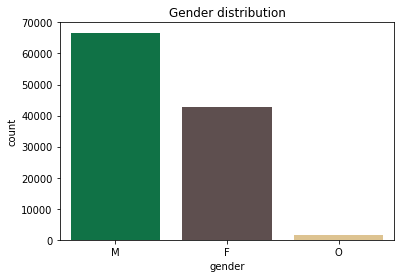

In [ ]:
import seaborn as sns

sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'trans_amount', 'income']]

ax = sns.countplot(x='gender', data=df)
ax.set_title('Gender distribution');

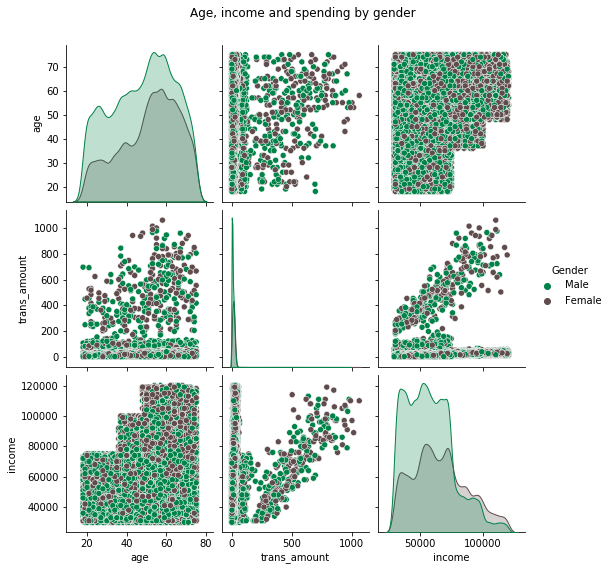

In [ ]:
sns.set_palette(sns.color_palette(starbucks))

df = transactions[['gender', 'age', 'trans_amount', 'income']].query('gender in ["F", "M"]')

df.rename(columns={'gender': 'Gender'}, inplace=True)
df['Gender'] = df['Gender'].map({'M': 'Male', 'F': 'Female'})

g = sns.pairplot(df, hue='Gender')
g.fig.suptitle("Age, income and spending by gender", y=1.05);

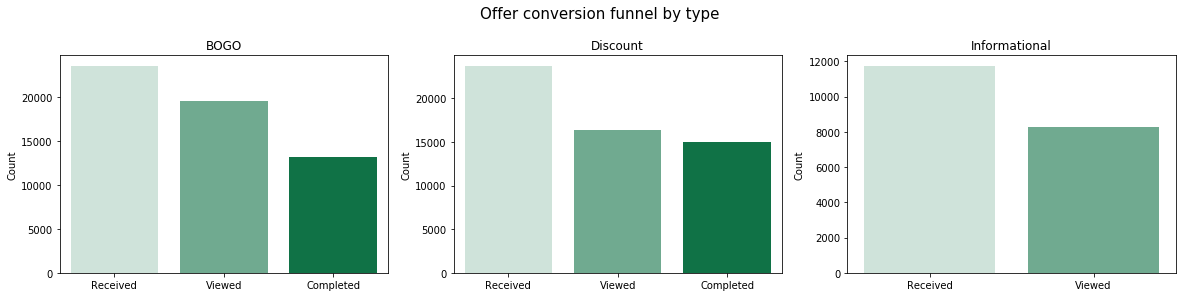

In [ ]:
import matplotlib.pyplot as plt
sns.set_palette(sns.color_palette(starbucks))

df = df4.groupby(['event','offer_type'])['person'].count().reset_index()
df['event'] = pd.Categorical(df['event'], ["offer received", "offer viewed", "offer completed"])
df.sort_values('event', inplace=True)

fig, axs = plt.subplots(ncols=3, figsize=(20, 4))

df['event'] = df['event'].map({'offer received': 'Received', 'offer viewed': 'Viewed', 'offer completed': 'Completed'})

ax = sns.barplot('event', y='person', data=df.query('offer_type == "bogo"'), palette=starbucks_d, ci=None, ax=axs[0])
ax.set(xlabel='', ylabel='Count', title='BOGO')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "discount"'), palette=starbucks_d, ci=None, ax=axs[1])
ax.set(xlabel='', ylabel='Count', title='Discount')

ax = sns.barplot('event', y='person', data=df.query('offer_type == "informational"'), palette=starbucks_d, ci=None, ax=axs[2])
ax.set(xlabel='', ylabel='Count', title='Informational')

fig.suptitle('Offer conversion funnel by type', size=15, y=1.05);

## Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
scaler = StandardScaler().fit(cust)
customers_scaled = scaler.transform(cust)
customers_scaled.std(axis=0)[:5], customers_scaled.mean(axis=0)[:5]

(array([1., 1., 1.]),
 array([-1.98537244e-17,  2.48171555e-17,  1.81992473e-17]))

## Dimensionality reduction

In [ ]:
pca = PCA()
X_pca = pca.fit_transform(customers_scaled)

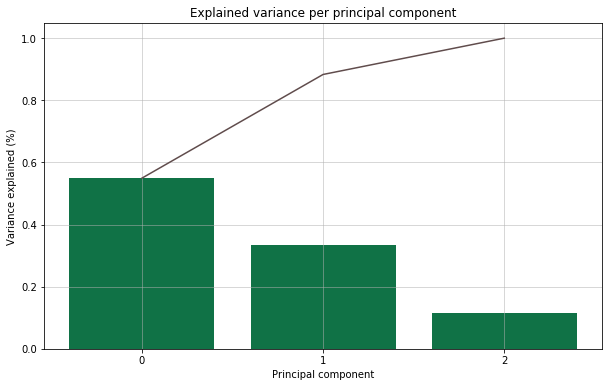

In [ ]:
# Scree plot (variance explained by each principal component)
import numpy as np
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
cumvals = np.cumsum(vals)

plt.figure(figsize=(10,6))

ax = sns.barplot(ind, vals, palette=starbucks[:1], ci=None)
ax2 = sns.lineplot(ind, cumvals, color=starbucks[1], ci=None)
ax.grid(b=True, which='major', linewidth=0.5)

ax.set_xlabel("Principal component")
ax.set_ylabel("Variance explained (%)")
plt.title('Explained variance per principal component');

In [ ]:
cum_expl_var_ratio = np.cumsum(pca.explained_variance_ratio_)
num_components = len(cum_expl_var_ratio[cum_expl_var_ratio <= 0.8])

# rerun PCA with components that explain 80% of the variance
pca = PCA(num_components).fit(customers_scaled)
X_pca = pca.transform(customers_scaled)
X_pca = pd.DataFrame(X_pca)

np.cumsum(pca.explained_variance_ratio_)

array([0.5493403])

## K-means

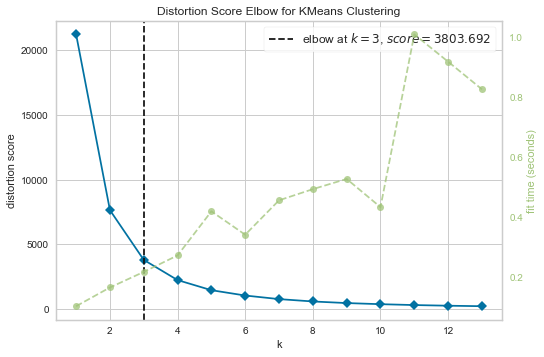

In [ ]:
# elbow method
from sklearn.cluster import KMeans
from yellowbrick.cluster.elbow import kelbow_visualizer

kelbow_visualizer(KMeans(), X_pca, k=(1,14));

In [ ]:
model = KMeans(n_clusters=4, random_state=28).fit(X_pca)
kmeans_clusters = model.predict(X_pca)

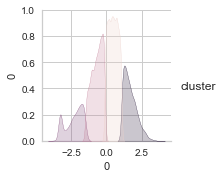

In [ ]:
df = X_pca.copy()
df['cluster'] = kmeans_clusters
sns.pairplot(df, hue='cluster')

In [ ]:
from sklearn.cluster import OPTICS
model = OPTICS(min_samples=40)
optics_clusters = model.fit_predict(X_pca)

print("Number of clusters:", len(np.unique(optics_clusters)))

Number of clusters: 125
